# TorchVision Object Detection Finetuning Tutorial

**在本教程中，我们将对预训练的 Mask R-CNN 模型进行微调，使用 Penn-Fudan 数据库进行行人检测和分割。该数据库包含 170 张图像和 345 个行人实例，我们将利用它来演示如何使用 torchvision 中的新功能，以便在自定义数据集上训练对象检测和实例分割模型。**


In [1]:
from pathlib import Path
import os
import matplotlib.pyplot as plt
import torch
import torchvision
from torchvision.io import read_image
from torchvision.ops.boxes import masks_to_boxes
from torchvision import tv_tensors
from torchvision.transforms.v2 import functional as F

DATA_DIR = Path.home() / "data"

In [2]:
image = read_image(DATA_DIR / "PennFudanPed/PNGImages/FudanPed00046.png")
mask = read_image(DATA_DIR / "PennFudanPed/PedMasks/FudanPed00046_mask.png")


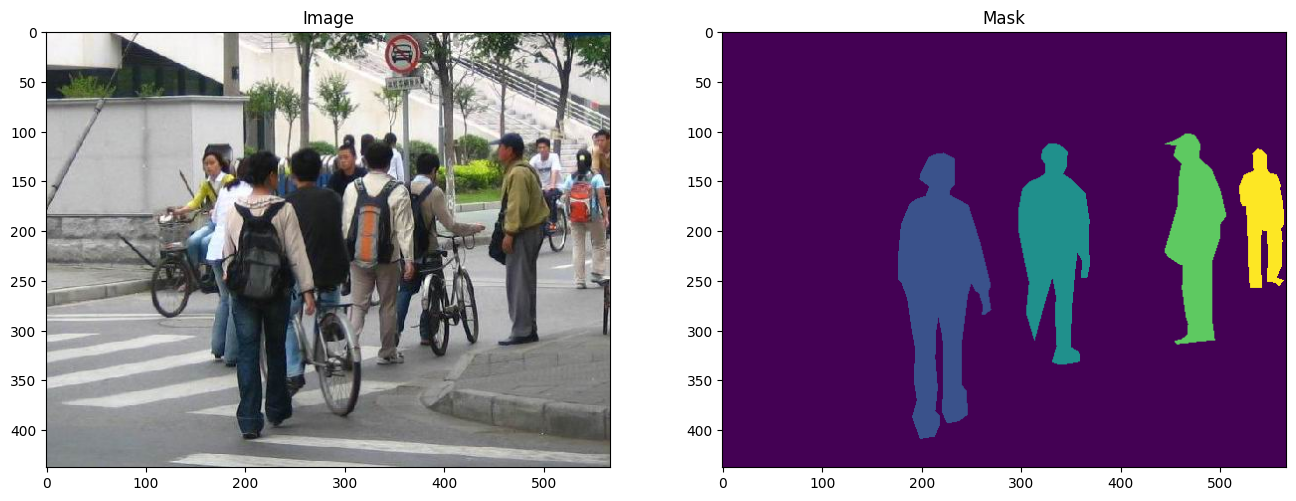

In [3]:
plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Mask")
plt.imshow(mask.permute(1, 2, 0))

## Defining the Dataset

用于训练目标检测、实例分割和人体关键点检测的参考脚本允许轻松支持添加新的自定义数据集。数据集应继承自标准 torch.utils.data.Dataset 类，并实现 `__len__` 和 `__getitem__` 。

我们唯一要求的特定性是数据集 `__getitem__` 应返回一个元组：

- image: torchvision.tv_tensors.Image 的形状为 [3, H, W] ，一个纯张量，或大小为 (H, W) 的 PIL 图像
- target: 一个包含以下字段的字典
  - boxes: torchvision.tv_tensors.BoundingBoxes 的形状为 [N, 4] : N 边界框的坐标，格式为 [x0, y0, x1, y1] ，范围从 0 到 W 和 0 到 H
  - labels: int torch.Tensor ，形状为 [N] ：每个边界框的标签。 0 始终表示背景类。
  - image_id: int 图像标识符。它在数据集中所有图像之间应该是唯一的，并在评估期间使用。
  - area: float torch.Tensor ，形状为 [N] ：每个边界框的面积，以像素为单位。
  - iscrowd: torch.Tensor ，形状为 [N] ：一个布尔值，表示每个边界框是否是 crowdfloat torch.Tensor ，形状为 [N] ：边界框的面积。这在使用 COCO 指标进行评估时使用，以区分小型、中型和大型框的指标分数。
  - iscrowd: uint8 torch.Tensor 的形状为 [N] : 在评估期间将忽略具有 iscrowd=True 的实例。
  - masks（可选）: torchvision.tv_tensors.Mask 形状为 [N, H, W] ：每个对象的分割掩码

如果您的数据集符合上述要求，则它将适用于参考脚本中的训练和评估代码。评估代码将使用来自 pycocotools 的脚本，可以通过 pip install pycocotools 进行安装。

关于 labels 的一点说明。模型将类 0 视为背景。如果您的数据集中不包含背景类，则在您的 labels 中不应包含 0 。例如，假设您只有两个类，猫和狗，您可以定义 1 （而不是 0 ）来表示猫， 2 来表示狗。因此，例如，如果其中一张图像同时包含这两个类，则您的 labels 张量应如下所示 [1, 2] 。

此外，如果您希望在训练期间使用纵横比分组（以便每个批次仅包含具有相似纵横比的图像），则建议还实现一个 get_height_and_width 方法，该方法返回图像的高度和宽度。如果未提供此方法，我们将通过 `__getitem__` 查询数据集的所有元素，这会将图像加载到内存中，并且比提供自定义方法要慢。


In [4]:
class PennFudanDataset(torch.utils.data.Dataset):
  def __init__(self, root, transforms):
    self.root = root
    self.transforms = transforms
    # load all image files, sorting them to
    # ensure that they are aligned
    self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
    self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

  def __getitem__(self, idx):
    # load images and masks
    img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
    mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
    img = read_image(img_path)
    mask = read_image(mask_path)
    # instances are encoded as different colors
    obj_ids = torch.unique(mask)
    # first id is the background, so remove it
    obj_ids = obj_ids[1:]
    num_objs = len(obj_ids)

    # split the color-encoded mask into a set
    # of binary masks
    masks = (mask == obj_ids[:, None, None]).to(dtype=torch.uint8)

    # get bounding box coordinates for each mask
    boxes = masks_to_boxes(masks)

    # there is only one class
    labels = torch.ones((num_objs,), dtype=torch.int64)

    image_id = idx
    area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
    # suppose all instances are not crowd
    iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

    # Wrap sample and targets into torchvision tv_tensors:
    img = tv_tensors.Image(img)

    target = {}
    target["boxes"] = tv_tensors.BoundingBoxes(boxes, format="XYXY", canvas_size=F.get_size(img))
    target["masks"] = tv_tensors.Mask(masks)
    target["labels"] = labels
    target["image_id"] = image_id
    target["area"] = area
    target["iscrowd"] = iscrowd

    if self.transforms is not None:
      img, target = self.transforms(img, target)

    return img, target

  def __len__(self):
    return len(self.imgs)

## Defining your model

在本教程中，我们将使用 Mask R-CNN，它是基于 Faster R-CNN 的。Faster R-CNN 是一个模型，用于预测图像中潜在对象的边界框和类别分数。

Mask R-CNN 在 Faster R-CNN 中添加了一个额外的分支，该分支还为每个实例预测分割掩码。


### 1 - Finetuning from a pretrained model

假设您想从一个在 COCO 上预训练的模型开始，并希望针对您的特定类别进行微调。以下是一种可能的实现方式：


In [5]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

# load a model pre-trained on COCO
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")

# replace the classifier with a new one, that has
# num_classes which is user-defined
num_classes = 2  # 1 class (person) + background
# get number of input features for the classifier
in_features = model.roi_heads.box_predictor.cls_score.in_features
# replace the pre-trained head with a new one
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

### 2 - Modifying the model to add a different backbone


In [6]:
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

# load a pre-trained model for classification and return
# only the features
backbone = torchvision.models.mobilenet_v2(weights="DEFAULT").features
# ``FasterRCNN`` needs to know the number of
# output channels in a backbone. For mobilenet_v2, it's 1280
# so we need to add it here
backbone.out_channels = 1280

# let's make the RPN generate 5 x 3 anchors per spatial
# location, with 5 different sizes and 3 different aspect
# ratios. We have a Tuple[Tuple[int]] because each feature
# map could potentially have different sizes and
# aspect ratios
anchor_generator = AnchorGenerator(
  sizes=((32, 64, 128, 256, 512),), aspect_ratios=((0.5, 1.0, 2.0),)
)

# let's define what are the feature maps that we will
# use to perform the region of interest cropping, as well as
# the size of the crop after rescaling.
# if your backbone returns a Tensor, featmap_names is expected to
# be [0]. More generally, the backbone should return an
# ``OrderedDict[Tensor]``, and in ``featmap_names`` you can choose which
# feature maps to use.
roi_pooler = torchvision.ops.MultiScaleRoIAlign(
  featmap_names=["0"], output_size=7, sampling_ratio=2
)

# put the pieces together inside a Faster-RCNN model
model = FasterRCNN(
  backbone, num_classes=2, rpn_anchor_generator=anchor_generator, box_roi_pool=roi_pooler
)

### Object detection and instance segmentation model for PennFudan Dataset

在我们的案例中，我们希望从一个预训练模型进行微调，因为我们的数据集非常小，所以我们将遵循方法一。

在这里，我们还想计算实例分割掩码，因此我们将使用 Mask R-CNN：


In [7]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_model_instance_segmentation(num_classes):
  # load an instance segmentation model pre-trained on COCO
  model = torchvision.models.detection.maskrcnn_resnet50_fpn(weights="DEFAULT")

  # get number of input features for the classifier
  in_features = model.roi_heads.box_predictor.cls_score.in_features
  # replace the pre-trained head with a new one
  model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

  # now get the number of input features for the mask classifier
  in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
  hidden_layer = 256
  # and replace the mask predictor with a new one
  model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask, hidden_layer, num_classes)

  return model

## Putting everything together


In [8]:
# os.system(
#   "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/engine.py"
# )
# os.system(
#   "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/utils.py"
# )
# os.system(
#   "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_utils.py"
# )
# os.system(
#   "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/coco_eval.py"
# )
# os.system(
#   "wget https://raw.githubusercontent.com/pytorch/vision/main/references/detection/transforms.py"
# )

In [9]:
from torchvision.transforms import v2 as T


def get_transform(train):
  transforms = []
  if train:
    transforms.append(T.RandomHorizontalFlip(0.5))
  transforms.append(T.ToDtype(torch.float, scale=True))
  transforms.append(T.ToPureTensor())
  return T.Compose(transforms)

## Testing forward() method (Optional)

在遍历数据集之前，查看模型在训练和推理时对样本数据的期望是很好的。


In [10]:
import utils

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights="DEFAULT")
dataset = PennFudanDataset(DATA_DIR / "PennFudanPed", get_transform(train=True))
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

# For Training
images, targets = next(iter(data_loader))
images = list(image for image in images)
targets = [{k: v for k, v in t.items()} for t in targets]
output = model(images, targets)  # Returns losses and detections
print(output)

# For inference
model.eval()
x = [torch.rand(3, 300, 400), torch.rand(3, 500, 400)]
predictions = model(x)  # Returns predictions
print(predictions[0])

{'loss_classifier': tensor(0.3402, grad_fn=<NllLossBackward0>), 'loss_box_reg': tensor(0.0308, grad_fn=<DivBackward0>), 'loss_objectness': tensor(0.0849, grad_fn=<BinaryCrossEntropyWithLogitsBackward0>), 'loss_rpn_box_reg': tensor(0.0028, grad_fn=<DivBackward0>)}
{'boxes': tensor([], size=(0, 4), grad_fn=<StackBackward0>), 'labels': tensor([], dtype=torch.int64), 'scores': tensor([], grad_fn=<IndexBackward0>)}


### 现在让我们编写执行训练和验证的主函数：


In [11]:
from engine import train_one_epoch, evaluate

# train on the GPU or on the CPU, if a GPU is not available
device = (
  torch.device("cuda:0")
  if torch.cuda.is_available()
  # else torch.device("mps")
  # if torch.backends.mps.is_available()
  else torch.device("cpu")
)
print(device)

# our dataset has two classes only - background and person
num_classes = 2
# use our dataset and defined transformations
dataset = PennFudanDataset(DATA_DIR / "PennFudanPed", get_transform(train=True))
dataset_test = PennFudanDataset(DATA_DIR / "PennFudanPed", get_transform(train=False))

# split the dataset in train and test set
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
  dataset, batch_size=2, shuffle=True, collate_fn=utils.collate_fn
)

data_loader_test = torch.utils.data.DataLoader(
  dataset_test, batch_size=1, shuffle=False, collate_fn=utils.collate_fn
)

# get the model using our helper function
model = get_model_instance_segmentation(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

# let's train it just for 2 epochs
num_epochs = 2

for epoch in range(num_epochs):
  # train for one epoch, printing every 10 iterations
  train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
  # update the learning rate
  lr_scheduler.step()
  # evaluate on the test dataset
  evaluate(model, data_loader_test, device=device)

print("That's it!")

cpu


/Users/yangjing/learn/learn-ai/pytorch/image-video/engine.py:32: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(enabled=scaler is not None):


Epoch: [0]  [ 0/60]  eta: 0:04:56  lr: 0.000090  loss: 2.6420 (2.6420)  loss_classifier: 0.5900 (0.5900)  loss_box_reg: 0.2618 (0.2618)  loss_mask: 1.7418 (1.7418)  loss_objectness: 0.0431 (0.0431)  loss_rpn_box_reg: 0.0052 (0.0052)  time: 4.9441  data: 0.0126
Epoch: [0]  [10/60]  eta: 0:04:25  lr: 0.000936  loss: 1.4786 (1.8853)  loss_classifier: 0.4617 (0.4292)  loss_box_reg: 0.3193 (0.2918)  loss_mask: 0.6575 (1.1388)  loss_objectness: 0.0146 (0.0192)  loss_rpn_box_reg: 0.0052 (0.0063)  time: 5.3011  data: 0.0159
Epoch: [0]  [20/60]  eta: 0:03:26  lr: 0.001783  loss: 1.0131 (1.3588)  loss_classifier: 0.2580 (0.3120)  loss_box_reg: 0.2791 (0.2815)  loss_mask: 0.4989 (0.7336)  loss_objectness: 0.0169 (0.0229)  loss_rpn_box_reg: 0.0059 (0.0088)  time: 5.1800  data: 0.0158
Epoch: [0]  [30/60]  eta: 0:02:32  lr: 0.002629  loss: 0.5954 (1.0828)  loss_classifier: 0.1002 (0.2329)  loss_box_reg: 0.2266 (0.2553)  loss_mask: 0.2303 (0.5689)  loss_objectness: 0.0148 (0.0180)  loss_rpn_box_reg: 

所以经过一个训练周期，我们获得了 COCO 风格的 mAP > 50，以及 mask mAP 为 65。

但是预测结果是什么样的呢？让我们取数据集中一张图像进行验证


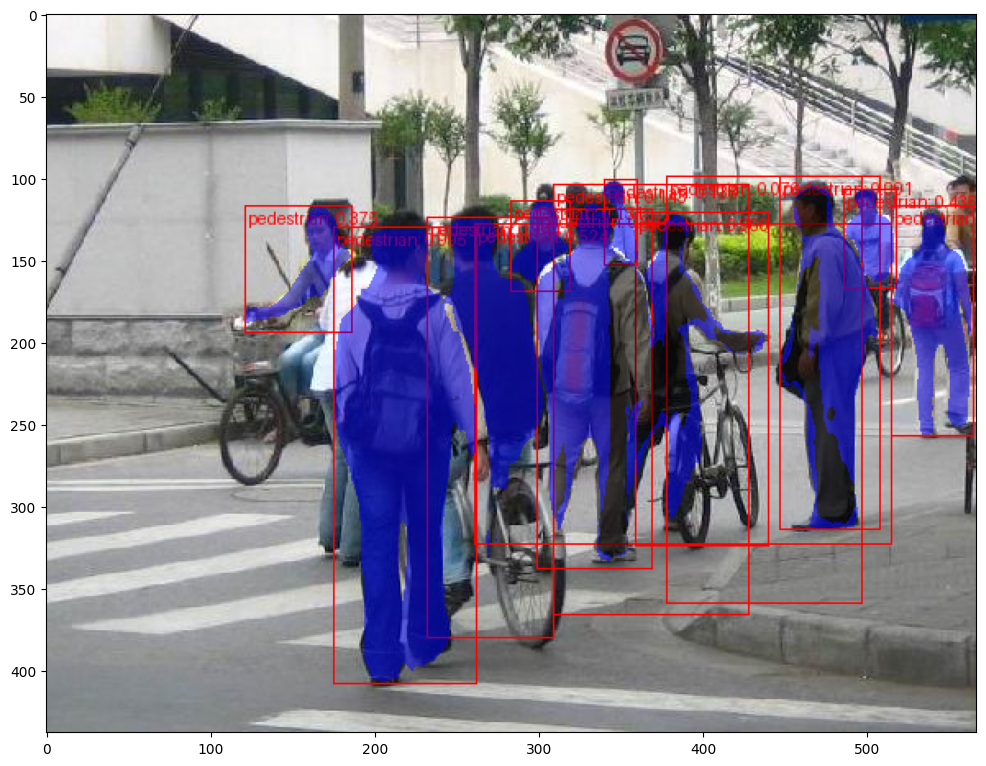

In [12]:
import matplotlib.pyplot as plt

from torchvision.utils import draw_bounding_boxes, draw_segmentation_masks


image = read_image(DATA_DIR / "PennFudanPed/PNGImages/FudanPed00046.png")
eval_transform = get_transform(train=False)

model.eval()
with torch.no_grad():
  x = eval_transform(image)
  # convert RGBA -> RGB and move to device
  x = x[:3, ...].to(device)
  predictions = model(
    [
      x,
    ]
  )
  pred = predictions[0]


image = (255.0 * (image - image.min()) / (image.max() - image.min())).to(torch.uint8)
image = image[:3, ...]
pred_labels = [f"pedestrian: {score:.3f}" for label, score in zip(pred["labels"], pred["scores"])]
pred_boxes = pred["boxes"].long()
output_image = draw_bounding_boxes(image, pred_boxes, pred_labels, colors="red")

masks = (pred["masks"] > 0.7).squeeze(1)
output_image = draw_segmentation_masks(output_image, masks, alpha=0.5, colors="blue")


plt.figure(figsize=(12, 12))
plt.imshow(output_image.permute(1, 2, 0))